# Channel network and REW delineation 

In this notebook, we'll cover the steps required to extract the REW channel network. This tutorial is specific to GRASS 7.0 and the Mac operating system (OS X). We have been most succesful with and recommend installing the GRASS 7.0.x files maintained by Michael Barton, which can be found [here](https://grass.osgeo.org/download/software/mac-osx/). Newer versions of GRASS (`7.3.x`) exist, but have not been tested for this tutorial. NOTE: For newer versions of OS X (El Capitan and on), users may need to implement [this](http://grassmac.wikidot.com) fix to get GRASS to run succesfully. 

In [1]:
%matplotlib inline
from matplotlib import pylab
import os
import sys
from os.path import dirname
import pickle
import gdal
import fiona
import glob
import shapely
import numpy as np
import shapely
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import geopandas as gp
import seaborn as sns
import pyproj
parent_dir = dirname(dirname(os.getcwd()))
sys.path.append(os.path.join(parent_dir,'StreamflowTempModel','1_data_preparation'))
sys.path.append(os.path.join(parent_dir,'StreamflowTempModel','2_hillslope_discharge'))

## Clip DEM and extract stream network

First, we would like to make sure that our digital elevation model (DEM) is clipped to the modeling region. This step is necessary due to the fact that the elevation file currently in the `raw_data/dem` folder is a full National Elevation Dataset (NED) tile, which is much larger than the computational domain of our watershed. 

Next, perform our network extraction analysis on the DEM. We will do all of this operating GRASS from a BASH command line. The particulars here are a bit messy, but essentially we create a temporary workspace for GRASS, open the DEM, perform the extraction, then close everything and cleanup. The main script used for extracting the network can be found in `1_data_preparation/extract_stream_basins_topology.sh`.

In [2]:
%%bash
############## SET WATERSHED NAME #####################
WATERSHED_POLY_NAME=sf_branscomb
echo $WATERSHED_POLY_NAME > ../temp/watershedname.txt

############## CLIP DEM TO WATERSHED OF INTEREST #####################
export PATH=/Library/Frameworks/GDAL.framework/Programs:$PATH
export PROJSO=/Library/Frameworks/PROJ.framework/PROJ
export MASTER_DEM=../../raw_data/dem/ned_eel_filled.tif
export WATERSHED_POLY=../../raw_data/watershed_poly/$WATERSHED_POLY_NAME.shp
rm ../../raw_data/dem/dem.tif
gdalwarp -cutline $WATERSHED_POLY -crop_to_cutline $MASTER_DEM ../../raw_data/dem/dem.tif

############## SETUP GRASS TO EXTRACT STREAM NETWORK #####################
# make the script executable for GRASS 
chmod u+x ../1_data_preparation/extract_stream_basins_topology.sh
# create folder to store temporary grass location
DBASE=../../grassdata
mkdir $DBASE
# setup GRASS setup file to find database. This step is necessary when using GRASS from the command line. 
echo "LOCATION_NAME: 
GISDBASE:$DBASE
MAPSET: 
GUI: 
PID:" > $HOME/.grass7/rc
/Applications/GRASS-7.4.1.app/Contents/MacOS/Grass.sh -text -c ../../raw_data/dem/dem.tif ../../grassdata/mylocation

Creating output file that is 778P x 510L.
Processing input file ../../raw_data/dem/ned_eel_filled.tif.
Using internal nodata values (e.g. -99999) for image ../../raw_data/dem/ned_eel_filled.tif.
Copying nodata values from source ../../raw_data/dem/ned_eel_filled.tif to destination ../../raw_data/dem/dem.tif.
0...10...20...30...40...50...60...70...80...90...100 - done.
Rebuilding Addon HTML manual pages index...
Rebuilding Addon menu...


Cleaning up temporary files...
ERROR: Variable 'LOCATION_NAME' not set
Creating new GRASS GIS location/mapset...

          __________  ___   __________    _______________
         / ____/ __ \/   | / ___/ ___/   / ____/  _/ ___/
        / / __/ /_/ / /| | \__ \\_  \   / / __ / / \__ \
       / /_/ / _, _/ ___ |___/ /__/ /  / /_/ // / ___/ /
       \____/_/ |_/_/  |_/____/____/   \____/___//____/

Welcome to GRASS GIS 7.4.1
GRASS GIS homepage:                      http://grass.osgeo.org
This version running through:            Bash Shell (/bin/bash)
Help is available with the command:      g.manual -i
See the licence terms with:              g.version -c
See citation options with:               g.version -x
Start the GUI with:                      g.gui wxpython
When ready to quit enter:                exit

Cleaning up temporary files...
Done.

Goodbye from GRASS GIS



In [3]:
%%bash
# Channel head initiation in meters2, dem resolution in meters
export THRESHMETERS=2500000
# define minimum 1st order stream length in meters. 
export MINSTREAMMETERS=400

# Keep the script quiet; comment this out if you want to debug
GRASS_VERBOSE=0
export GRASS_VERBOSE

############## USE GRASS TO EXTRACT STREAM NETWORK #####################
# Get watershed name from previous cell
WATERSHED_POLY_NAME=$(head -n 1 ../temp/watershedname.txt)
# define the job file as environmental variable
export GRASS_BATCH_JOB="../1_data_preparation/extract_stream_basins_topology.sh"
# must set path to model folder for .sh script so it can find necessary files and store output
export MODEL=../../
# now we can use the temp location and run the job defined via GRASS_BATCH_JOB
/Applications/GRASS-7.4.1.app/Contents/MacOS/Grass.sh --quiet ../../grassdata/mylocation/PERMANENT
# CLEANUP
unset GRASS_BATCH_JOB
# delete temporary location
rm -rf ../../grassdata/
# clear out rc file so that the GRASS GUI opens properly on next opening
echo "LOCATION_NAME: 
GISDBASE:
MAPSET: 
GUI: 
PID:" > $HOME/.grass7/rc

Rebuilding Addon HTML manual pages index...
Rebuilding Addon menu...
projection: 1 (UTM)
zone:       10
datum:      nad83
ellipsoid:  grs80
north:      4397288.32977403
south:      4383832.40133984
west:       437372.90117634
east:       457916.20565076
nsres:      26.3841734
ewres:      26.40527567
rows:       510
cols:       778
cells:      396780
projection: 1 (UTM)
zone:       10
datum:      nad83
ellipsoid:  grs80
north:      4397288.32977403
south:      4383832.40133984
west:       437372.90117634
east:       457916.20565076
nsres:      26.3841734
ewres:      26.40527567
rows:       510
cols:       778
cells:      396780
Cell area is 696.68137195
Cells threshold is 3588


Cleaning up temporary files...
Starting GRASS GIS...
Executing <../1_data_preparation/extract_stream_basins_topology.sh> ...
         parameter.
ERROR 6: Failed to add field named 'next_stream'
ERROR 6: Failed to add field named 'scheidegger'
ERROR 6: Failed to add field named 'source_elev'
ERROR 6: Failed to add field named 'outlet_elev'
         feature type.
         feature type.
         feature type.
Execution of <../1_data_preparation/extract_stream_basins_topology.sh> finished.
Cleaning up temporary files...


## Extracted REWs

Let's take a look at the REWs extracted using the above script. Here, we import the polygons corresponding to each REW, and map these REWs with labels corresponding to the REW identification number (which will be used extensively throughout these tutorials). 

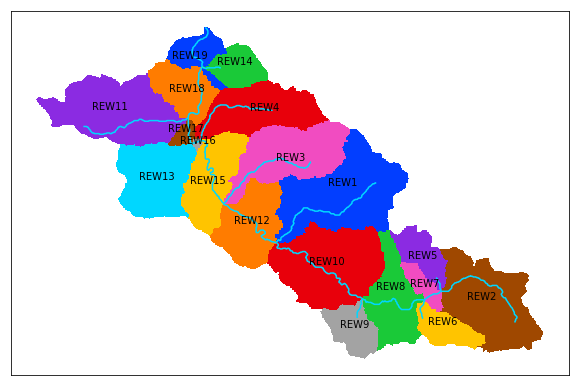

In [4]:
basins = glob.glob(os.path.join(parent_dir,'raw_data','basins_poly','*.shp'))[0]
basins_shape = gp.GeoDataFrame.from_file(basins)
basins_shape['coords'] = basins_shape['geometry'].apply(lambda x: x.representative_point().coords[:])
basins_shape['coords'] = [coords[0] for coords in basins_shape['coords']]

f,ax1 = plt.subplots(1,figsize=(10,7))
cs = sns.color_palette('bright',len(basins_shape)+1)
basins_shape.plot(ax=ax1, color=cs)

for idx, row in basins_shape.iterrows():
    print_str = 'REW' + str(row['cat'])
    plt.annotate(s=print_str, xy=row['coords'],
                 horizontalalignment='center',fontsize=10)
try: 
    streams = glob.glob(os.path.join(parent_dir,'raw_data','streams_poly','*.shp'))[0]
    streams_shape = gp.GeoDataFrame.from_file(streams)
    streams_shape.plot(ax=ax1,color=cs[-1])
except: 
    print('There are no identified streams. Watershed can only be run as a single hillslope.')
    
ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])
ax1.patch.set_facecolor('white')